# 📊 Lab 01 - Group 04

This is the submission of the lab 01 of Data Science course of Group 04. We will do the data scrapping on three hotels booking websites, including:
- [Booking.com](https://www.booking.com)
- [Agoda.com](https://www.agoda.com/en-gb/)
- [Trivago.com](https://www.trivago.fi)

We retrieve the following information including: hotel name, hotel link, list of hotel images, hotel star, hotel review score, number of reviews, distance to the city center and price per night.

## Install required packages

In [ ]:
# Install required packages
%pip install selenium  
%pip install selenium-stealth
%pip install pandas

## Import libraries

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium_stealth import stealth
import time
from tqdm import tqdm
import pandas as pd
from IPython.display import HTML, display
import re

## Web scrapping

We search for the hotels on three different websites with following searching parameters:
- Destination: Berlin, Germany
- Start date: 22th December
- End date: 26th December
- Two adults
- One room

### Booking.com

For booking.com we are using an url that already has the desired dates set in as checkin and checkout (Dec 22- Dec 26). First we accept the cookies banner and close a login popup that covers the page. Next we identified that the information for the hotels is in the card containers. The find_elements function grabs all of the cards that it can, usually around 20 hotels. From each card we are able to get the name of the hotel, the ratings, the number of reviews, the number of stars, the price, the distance from downtown, and the link. Once the available cards are all read, we scroll down to get more hotels. After 50 hotels information has been collected, we go to the link of each hotel to get remaining information such as: 3 images, description, and the address.

The data was stored in a list of dictionaries that we then passed to a pandas data structure. We also made sure that the numerical values were numerical data types like integers or floats.

We faced several challenges as booking.com worked differently when running on google collab vs locally. The webpage opened in collab would not hold the information of the checkin and checkout dates for some reason so we finished the code in our local jupyter notebooks. Getting rid of the cookies banner was an interesting challenge but as long as the button was identified it was easy to close. Lastly, booking.com has two different ways of displaying the stars of the hotels, either as circles or stars and they are both different containers, so the code had to adjust to search for both kind of containers. Finally, we do a check to see whether the distance from downtown is in km or m since there was one hotel that had a different unit than the rest.

In [ ]:
no_hotels = 50
options = Options()
options.headless = True 
driver = webdriver.Chrome(options=options)

url = "https://www.booking.com/searchresults.html?ss=Berlin&ssne=Berlin&ssne_untouched=Berlin&efdco=1&label=gen173nr-10CAQoggJCL3NlYXJjaF9iZXJsaW4sIGJlcmxpbiBmZWRlcmFsIHN0YXRlLCBnZXJtYW554oCmSDNYBGhIiAEBmAEzuAEXyAEM2AED6AEB-AEBiAIBqAIBuALByIDGBsACAdICJGY3YjA1OTQyLWExZGUtNDJmZS05MTljLWVmM2I3N2E1YTQzNtgCAeACAQ&aid=356980&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-1746443&dest_type=city&checkin=2025-12-22&checkout=2025-12-26&group_adults=2&no_rooms=1&group_children=0"
driver.get(url)
print(driver.title)

try:
    cookie_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))
    )
    cookie_button.click()
    print("Cookies banner closed.")
except:
    print("No cookie banner found (maybe already dismissed).")

WebDriverWait(driver, 15).until(
    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div[data-testid='property-card']"))
)

hotels = []
while len(hotels) < no_hotels:
    all_cards = driver.find_elements(By.CSS_SELECTOR, "div[data-testid='property-card']")
    
    new_cards = all_cards[len(hotels):]
    
    if not new_cards:
        break

    for card in new_cards:
        if len(hotels) >= no_hotels:
            break

        try:
            name = card.find_element(By.CSS_SELECTOR, "div[data-testid='title']").text
        except:
            name = None

        try:
            price_full_text = card.find_element(By.CSS_SELECTOR, "span[data-testid='price-and-discounted-price']").text
            price = re.sub(r'[^\d.]', '', price_full_text)
            price = float(price)
        except:
            price = None

        try:
            distance_text = card.find_element(By.CSS_SELECTOR, "span[data-testid='distance']").text
            match = re.search(r'(\d+\.?\d*)\s*(km|m)\s*from downtown', distance_text)
            if match:
                value = float(match.group(1))
                unit = match.group(2)
                if unit == 'm':
                    distance = value / 1000
                else:
                    distance = value
            else:
                distance = None
        except:
            distance = None

        try:
            availability_link = card.find_element(By.CSS_SELECTOR, "a[data-testid='availability-cta-btn']").get_attribute("href")
        except:
            availability_link = None

        try:
            stars_text = card.find_element(By.CSS_SELECTOR, "div.b41575a678 div[aria-label]").get_attribute("aria-label")
            match = re.search(r'\d+\.?\d*', stars_text)
            if match:
                stars = float(match.group())
            else:
                stars = None
        except:
            stars = None

        try:
            rating_score_text = card.find_element(By.CSS_SELECTOR, "div[data-testid='review-score'] > div[aria-hidden='true']").text
            rating_score = float(rating_score_text)
        except:
            rating_score = None

        try:
            reviews_count_text = card.find_element(By.CSS_SELECTOR, "div.fff1944c52.fb14de7f14.eaa8455879").text
            reviews_count = re.sub(r'\D', '', reviews_count_text)
            reviews_count = int(reviews_count)
        except:
            reviews_count = None

        hotels.append({
            "name": name,
            "link": availability_link,
            "rating": rating_score,
            "num_reviews": reviews_count,
            "price": price,
            "distance_to_city_center": distance,
            "star": stars
        })

    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

for hotel in hotels:
    if hotel["link"]:
        driver.get(hotel["link"])

        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "p[data-testid='property-description']"))
            )
            description = driver.find_element(By.CSS_SELECTOR, "p[data-testid='property-description']").text
            hotel["description"] = description
        except:
            hotel["description"] = "Description not found."

        image_urls = []
        try:
            image_elements = driver.find_elements(By.CSS_SELECTOR, "img.f6c12c77eb")
            for i in range(min(3, len(image_elements))):
                src = image_elements[i].get_attribute("src")
                if src:
                    image_urls.append(src)
            hotel["images"] = image_urls
        except:
            hotel["images"] = []

        try:
            location_element = driver.find_element(By.CSS_SELECTOR, "div.b99b6ef58f.cb4b7a25d9.b06461926f")
            location_text = location_element.text
            review_text = location_element.find_element(By.CSS_SELECTOR, "div.dcf8588897").text
            location = location_text.replace(review_text, "").strip()
            hotel["address"] = location
        except:
            hotel["address"] = "Location not found."

# Print the final data with descriptions
for h in hotels[:3]:
    print(h)

driver.quit()

In [ ]:
df = pd.DataFrame(hotels)

# Save the DataFrame to a CSV file
df.to_csv("booking_data.csv", index=False)

print("Data saved to booking_data.csv")

### Agoda.com

For the Agoda website, the first result page already contains 90 hotels. On this page, we scraped all the information related to the hotel name, link, star rating, number of reviews, and distance to the city center. However, for the address and description, we needed to visit each hotel’s detail page through its link to extract the missing data.

There are certain challenges when scraping Agoda.com. Since the website is designed with a lazy-loading technique, we first had to scroll slowly four times. At each step, we paused to allow the page to load, then continued scrolling until no more content appeared. However, this only ensured that all results were displayed; each result still had its own lazy loading. We observed that the loading threshold was limited to three items at a time. Therefore, we divided the 90 results into multiple intervals, each containing three hotel items. Starting from the first page, we scraped three items, then moved to the next three, performing small up-and-down scrolls to ensure they were fully loaded, and repeated this process until we collected data across 50 pages.

In [ ]:
def initialize_driver(headless=True):
    # Initialize the Chrome driver
    options = webdriver.ChromeOptions()
    options.add_argument("start-maximized")

    if headless:
        options.add_argument("--headless")

    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)
    driver = webdriver.Chrome(options=options)

    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True,
            )

    url = "https://www.agoda.com/en-gb/search?guid=c26336df-50c1-44bb-9743-f9d55345b926&asq=NQVGXW6jsE3tbdY9S%2BqUCpufa9Vwpz6XltTHq4n%2B9gPt6Sc9VYM%2BOtJvOdzFsuZ%2FzAuvidgVQbMVJtWjbT5XSiV8O1SzHJ7Bv9omVvB8VpUlbnTC7%2FuflsT1o80V4bYmr6QDs48C6hOjLzuYUvlEgOm%2B3QacrQMDUE7JkJAfzu0qEfFok0%2FA1qOZi6L4zoeokKYGADqLl%2Fs%2FexkxVWVq8Q%3D%3D&city=2366&tick=638946550764&locale=en-gb&ckuid=0baefa65-874a-4374-9557-36f31b1cffa1&prid=0&currency=EUR&correlationId=45e635a9-a62a-4d9a-a0b8-45b9a922066d&analyticsSessionId=4826630106819138952&pageTypeId=1&realLanguageId=16&languageId=1&origin=FI&stateCode=19&cid=1844104&userId=0baefa65-874a-4374-9557-36f31b1cffa1&whitelabelid=1&loginLvl=0&storefrontId=3&currencyId=1&currencyCode=EUR&htmlLanguage=en-gb&cultureInfoName=en-gb&machineName=am-pc-4g-acm-web-user-6448bbf696-d5gvw&trafficGroupId=1&trafficSubGroupId=84&aid=130589&useFullPageLogin=true&cttp=4&isRealUser=true&mode=production&browserFamily=Chrome&cdnDomain=agoda.net&checkIn=2025-12-22&checkOut=2025-12-26&rooms=1&adults=2&children=0&priceCur=EUR&los=4&textToSearch=Berlin&productType=-1&travellerType=1&familyMode=off&ds=eIuvpYNUY6YfxpNr"
    driver.get(url)
    return driver


In [ ]:
def up_and_down_scroll(driver, pause_time=1.5, scroll_amount=200):
    current_position = driver.execute_script("return window.scrollY;")

    driver.execute_script(f"window.scrollTo(0, {current_position - scroll_amount});")
    time.sleep(pause_time)

    driver.execute_script(f"window.scrollTo(0, {current_position});")
    time.sleep(pause_time)

    driver.execute_script(f"window.scrollTo(0, {current_position + scroll_amount});")
    time.sleep(pause_time)

    driver.execute_script(f"window.scrollTo(0, {current_position});")
    time.sleep(pause_time)


In [ ]:
accommodation_name = []
accommodation_link = []
accommodation_img_data = []
accommodation_center_distance = []
accommodation_star = []
accommodation_rating = []
accommodation_num_reviews = []
accommodation_price = []
accomodation_address = []
accomodation_description = []

In [ ]:
def get_link_and_basic_info(driver):
    hard_scroll_length = 3600
    soft_scroll_length = 800
    lazy_threshold = 3
    scroll_threshold = 4
    scroll_pause_time = 4.5
    limit = 60

    for i in range(scroll_threshold):
        driver.execute_script(f"window.scrollBy(0, {hard_scroll_length*i});")
        time.sleep(scroll_pause_time)

    # Go to the top of the page
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(2)

    # Get all <li> elements with data-selenium="hotel-item"
    hotel_elements = driver.find_elements(By.CSS_SELECTOR, 'li[data-selenium="hotel-item"][data-hotelid]')
    print(f"Initial number of hotels found: {len(hotel_elements)}")

    scrape_idx = 0
    for hotel_element in tqdm(hotel_elements):
        info_element = hotel_element.find_element(By.TAG_NAME, 'a')
        hotel_link = info_element.get_attribute("href")
        hotel_name = info_element.get_attribute("aria-label")
        
        img_elements = hotel_element.find_elements(By.TAG_NAME, 'img')

        hotel_img_links = []
        for img in img_elements:
            img_src = img.get_attribute("src")
            hotel_img_links.append(img_src)

        near_city_element = hotel_element.find_element(By.CSS_SELECTOR, 'button[data-selenium="area-city-text"]')
        near_city_distance = near_city_element.text

        # Locate the rating container
        star_container = hotel_element.find_element(By.CSS_SELECTOR, 'div[data-testid="rating-container"]')

        # Get text from the screen reader span
        star = star_container.find_element(By.CSS_SELECTOR, "span").text
        star = float(star.split()[0])

        review_div = hotel_element.find_element(By.CSS_SELECTOR, 'div[data-element-name="property-card-review"]')

        rating = review_div.find_element(By.CSS_SELECTOR, "p span").text
        rating = float(rating)

        num_reviews = review_div.find_elements(By.CSS_SELECTOR, "p")[-1].text
        num_reviews = num_reviews.replace(" reviews", "").replace(" review", "")
        num_reviews = int(num_reviews.replace(",", ""))


        # Locate the price container
        price_div = hotel_element.find_element(By.CSS_SELECTOR, 'div[data-element-name="final-price"]')

        # Extract numeric price
        price = price_div.find_element(By.CSS_SELECTOR, 'span[data-selenium="display-price"]').text
        price = float(price)

        accommodation_name.append(hotel_name)
        accommodation_link.append(hotel_link)
        accommodation_img_data.append(hotel_img_links)
        accommodation_center_distance.append(near_city_distance)
        accommodation_star.append(star)
        accommodation_rating.append(rating)
        accommodation_num_reviews.append(num_reviews)
        accommodation_price.append(price)


        if len(accommodation_link) >= limit:
            break

        scrape_idx += 1
        if scrape_idx % lazy_threshold == 0:
            if scrape_idx == lazy_threshold:
                # Scroll back to the top of the page
                driver.execute_script("window.scrollTo(0, 1200);")
                time.sleep(scroll_pause_time)
            else:
                driver.execute_script(f"window.scrollBy(0, {soft_scroll_length});")
                time.sleep(scroll_pause_time)
            up_and_down_scroll(driver, pause_time=2)

In [ ]:
def get_details(driver, link):
    driver.get(link)
    time.sleep(5)

    # Locate the span by data-selenium attribute
    address_elem = driver.find_element(By.CSS_SELECTOR, 'span[data-selenium="hotel-address-map"]')

    # Extract the text
    address = address_elem.text

    try:
        # Locate by data-element-name
        desc_elem = driver.find_element(By.CSS_SELECTOR, 'span[data-element-name="property-short-description"]')

        # Get text content
        description = desc_elem.text
    except:
        description = None

    # Scroll up and down a little to act like a real user
    driver.execute_script("window.scrollBy(0, 600);")
    time.sleep(2)
    driver.execute_script("window.scrollBy(0, -600);")
    time.sleep(2)

    return address, description

In [ ]:
driver = initialize_driver()
get_link_and_basic_info(driver)

for link in tqdm(accommodation_link):
    address, description = get_details(driver, link)
    accomodation_address.append(address)
    accomodation_description.append(description)

driver.quit()

In [ ]:
accommodation_data = {
    "name": accommodation_name,
    "link": accommodation_link,
    "images": accommodation_img_data,
    "description": accomodation_description,
    "address": accomodation_address,
    "distance_to_city_center": accommodation_center_distance,
    "star": accommodation_star,
    "rating": accommodation_rating,
    "num_reviews": accommodation_num_reviews,
    "price": accommodation_price,
}

In [ ]:
df = pd.DataFrame(accommodation_data)

In [ ]:
def extract_distance(text):
    match = re.search(r"(\d+(?:\.\d+)?)\s*(m|km)", text)
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        if unit == "m":
            value /= 1000  # Convert meters to kilometers
        return value
    return 0

df['distance_to_city_center'] = df['distance_to_city_center'].apply(extract_distance)

In [ ]:
df.to_csv("agoda_data.csv", index=False)
df.head()

### Trivago.com

As we wanted to keep the data consistent across different websites, we focused on finding platforms that provided comparable information, such as the proximity of hotels to the city centre. Not all sites contained this data, so we chose Trivago.com. This site was a strong candidate because most of the relevant information was displayed directly on the main results page. With 35 hotels listed per page, scraping just two pages was sufficient to reach our target of 50 hotels.

The main challenge, however, was handling the cookie consent banner. At first, even when using the correct CSS selector, our attempts to click the “deny” button failed. We eventually discovered that the banner was contained within a shadow DOM. Unlike standard DOM scraping, where selectors can directly access elements, shadow DOMs encapsulate their content, blocking traditional queries and requiring explicit navigation into the shadow root. To complicate matters further, Trivago implemented a double shadow DOM, meaning two separate banner containers were present. Even if one was dismissed, the other could remain active and obstruct the page. It took us some time to realize that we needed to handle both containers to properly close the banner. This step demanded special logic that went beyond typical scraping techniques.
Once the banner was managed, we faced additional challenges collecting detailed information. Not all the desired data was immediately visible on the main card, so we had to interact with the “more details” section for each hotel to access summaries, addresses, and images. This required precise timing, since elements had to fully load before scraping could continue without errors. We also discovered that some information was restricted: certain prices were locked behind membership access, and for those hotels the “more details” option was not available. These limitations required careful handling to ensure that as much information as possible was gathered while maintaining the data consistency.

In [ ]:
def click_all_usercentrics_denies(driver, timeout=15):
    # Find all Usercentrics asides
    asides = WebDriverWait(driver, timeout).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "aside#usercentrics-cmp-ui"))
    )
    
    clicked = 0
    for aside in asides:
        shadow_root = driver.execute_script("return arguments[0].shadowRoot", aside)
        try:
            deny_button = shadow_root.find_element(By.CSS_SELECTOR, "button[data-action-type='deny']")
            driver.execute_script("arguments[0].scrollIntoView(true);", deny_button)
            driver.execute_script("arguments[0].click();", deny_button)
            print("Clicked deny button in one banner")
            clicked += 1
        except Exception as e:
            print("Could not click deny button:", e)
    
    if clicked == 0:
        print("No deny buttons found")
    else:
        print(f"Finished clicking {clicked} deny button(s)")

In [ ]:
driver = webdriver.Chrome()

# Apply selenium-stealth to the existing driver
stealth(
    driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="Win32",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)


url = "https://www.trivago.com/es/lm/hoteles-berl%C3%ADn-alemania?search=200-3848;dr-20251222-20251226-s;ds-3000;so-5"
driver.get(url)

click_all_usercentrics_denies(driver)

all_hotels = []

page_number = 1

while len(all_hotels) < 50:
    print(f"Scraping page {page_number}")

    container = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-testid='result-list-ready']"))
        )
    hotel_cards = container.find_elements(By.CSS_SELECTOR, "li[data-testid='accommodation-list-element']")

    for card in hotel_cards:
        try:
            name = card.find_element(By.CSS_SELECTOR, "button[data-testid='item-name']").text
        except:
            name = "N/A"
        try:
            link = card.find_element(By.CSS_SELECTOR, "button[data-testid='champion-deal']").get_attribute("data-url")
        except:
            link = None
        
        try:
            more_btn = card.find_element(By.CSS_SELECTOR, "button[data-testid='additional-prices-slideout-entry-point']")
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", more_btn)
            driver.execute_script("arguments[0].click();", more_btn)
            time.sleep(2)
            info_btn = card.find_element(By.CSS_SELECTOR, "button[data-testid='INFO']")
            driver.execute_script("arguments[0].click();", info_btn)
            time.sleep(2)
            desc = card.find_element(By.CSS_SELECTOR, "div[data-testid^='accommodation-description'] p").text

            address_parts = card.find_elements(By.CSS_SELECTOR, "ul[itemprop='address'] li")
            address = " ".join([part.text.strip() for part in address_parts])

            photo_btn = card.find_element(By.CSS_SELECTOR, "button[data-testid='IMAGES']")
            driver.execute_script("arguments[0].click();", photo_btn)
            time.sleep(5)
            images = driver.find_elements(By.CSS_SELECTOR, "img[data-testid='tile-gallery-image']")
            first_three = [img.get_attribute("src") for img in images[:3]]

            time.sleep(5)

        except:
            desc = "N/A"
            address = "N/A"
        try:
            distance_text = card.find_element(By.CSS_SELECTOR, "button[data-testid='distance-label-section']").text
            distance_to_city_center = distance_text.split()[0]
        except:
            distance_to_city_center = 0.0
        try:
            star =  card.find_element(By.CSS_SELECTOR, "button[data-testid='accommodation-type'] meta[itemprop='ratingValue']").get_attribute("content")
        except:
            star = 0.0
        try:
            rating = card.find_element(By.CSS_SELECTOR, "button[data-testid='rating-section'] meta[itemprop='ratingValue']").get_attribute("content")
        except:
            rating = 0.0
        try:
            num_reviews = card.find_element(By.CSS_SELECTOR, "button[data-testid='rating-section'] meta[itemprop='ratingCount']").get_attribute("content")
        except:
            num_reviews = 0
        try:
            price_text = card.find_element(By.CSS_SELECTOR, "div[data-testid='recommended-price']").text
            match = re.search(r"\d+", price_text)
            price = match.group() if match else None
        except:
            price = 0.0

        
        hotel_info = {
            "name": name,
            "link": link,
            "images": first_three,
            "description": desc,
            "address": address,
            "distance_to_city_center": float(distance_to_city_center),
            "star": float(star),
            "rating": float(rating),
            "num_reviews": int(num_reviews),
            "price": float(price)
        }

        all_hotels.append(hotel_info)
        if len(all_hotels) >= 50:
            break
    
    print(f"Scraped {len(hotel_cards)} hotels from page {page_number}, total hotels: {len(all_hotels)}")

    if len(all_hotels) < 50:
        try:
            page_number += 1
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, f"button[data-testid='result-page-{page_number}']"))
            )
            next_button.click()
            print(f"Clicked page {page_number}")
            time.sleep(10)

        except TimeoutException:
            print("No more pages available")
            break

In [ ]:
df = pd.DataFrame(all_hotels)
df.to_csv("trivago_data.csv", index=False)

## Data Merging and Cleaning

We stored the data in CSV files and then loaded them to merge into one final consolidated file. Although there were a number of duplicate elements, we chose not to remove them, as we wanted to preserve hotel information across different locations so that users can compare them later.

In [120]:
# Merged and cleaned data
df_booking = pd.read_csv("booking_data.csv")
df_agoda = pd.read_csv("agoda_data.csv")
df_trivago = pd.read_csv("trivago_data.csv")

df_booking["price"] = df_booking["price"]/4

In [89]:
# Remove duplicates based on 'name' and 'address' lowercase for each dataframe
df_booking_cleaned = df_booking.drop_duplicates(subset=['name', 'address'], keep='first')
df_agoda_cleaned = df_agoda.drop_duplicates(subset=['name', 'address'], keep='first')
df_trivago_cleaned = df_trivago.drop_duplicates(subset=['name', 'address'], keep='first')
len(df_booking_cleaned), len(df_agoda_cleaned), len(df_trivago_cleaned)

(50, 60, 50)

We can see that there are no duplicated hotels on three websites, which is good :>.

In [119]:
df_merged = pd.concat([df_booking_cleaned, df_agoda_cleaned, df_trivago_cleaned], ignore_index=True)
df_merged.to_csv("merged_accommodation_all_data.csv", index=False)

df_merged.head()

,name,link,rating,num_reviews,price,distance_to_city_center,star,description,images,address
0,Hotel Altes Fährhaus,https://www.booking.com/hotel/de/boutique-fahr...,8.3,1086,111.50,12.2,4.0,"Located in Berlin by the river Havel, Hotel Al...",['https://cf.bstatic.com/xdata/images/hotel/ma...,"Aalemannufer 31, Spandau, 13587 Berlin, Germany"
1,Hotel AMANO East Side,https://www.booking.com/hotel/de/amano-east-si...,8.4,7448,71.75,3.8,4.0,Comfortable Accommodations: Hotel AMANO East S...,['https://cf.bstatic.com/xdata/images/hotel/ma...,"Stralauer Platz 30-31, Friedrichshain-Kreuzber..."
2,Mercure Hotel MOA Berlin,https://www.booking.com/hotel/de/moa-berlin.ht...,8.5,5547,76.25,2.8,4.0,"Offering a unique atrium and free WiFi, this 4...",['https://cf.bstatic.com/xdata/images/hotel/ma...,"Stephanstr. 41, Mitte, 10559 Berlin, Germany"
3,Holiday Inn Express - Berlin - Alexanderplatz ...,https://www.booking.com/hotel/de/holiday-inn-e...,8.5,9719,97.25,2.4,3.0,The Holiday Inn Express - Berlin - Alexanderpl...,['https://cf.bstatic.com/xdata/images/hotel/ma...,"Stralauer Strasse 45, Mitte, 10179 Berlin, Ger..."
4,Locke at East Side Gallery,https://www.booking.com/hotel/de/locke-at-east...,9.2,2548,93.50,4.2,4.0,Comfortable Accommodations: Locke at East Side...,['https://cf.bstatic.com/xdata/images/hotel/ma...,"Mühlenstraße 61-63, Friedrichshain-Kreuzberg, ..."


In [101]:
# Check the nan values
df_merged.isna().sum()

# Remove rows with nan star
df_merged = df_merged.dropna(subset=['star'])

In [ ]:
df_merged.isna().sum()

name                        0
link                       50
rating                      0
num_reviews                 0
price                       0
distance_to_city_center     0
star                        0
description                17
images                      0
address                    14
dtype: int64

## Exploratory Data Analysis (EDA)

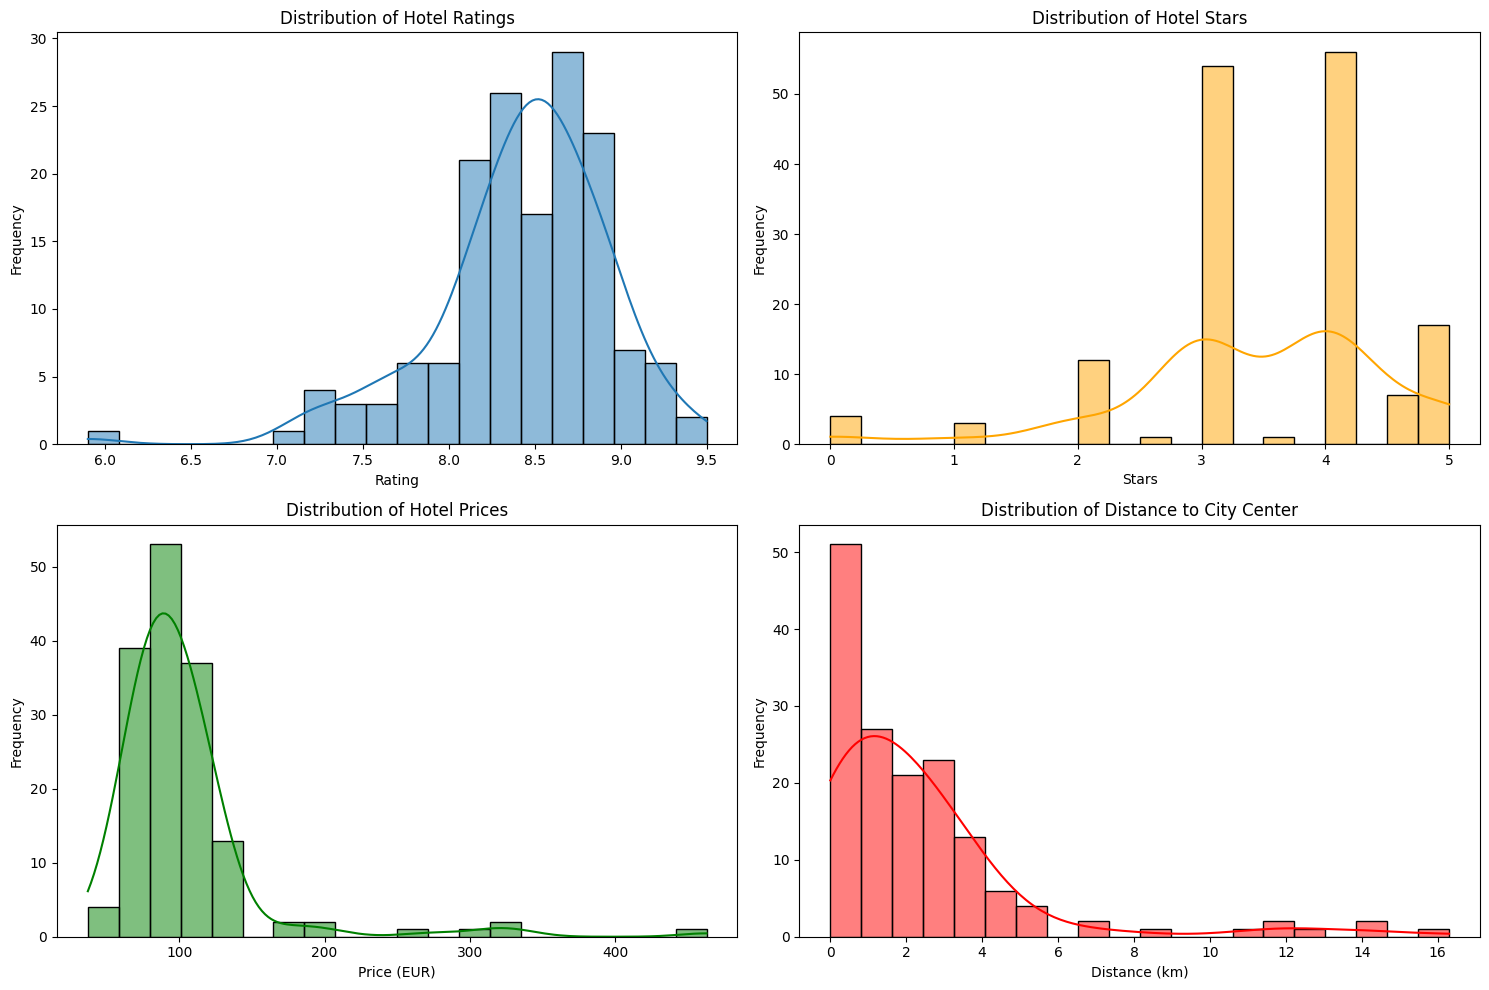

In [103]:
# Distribution of hotel ratings, stars, and prices, distance to city center
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df_merged['rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Hotel Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.subplot(2, 2, 2)
sns.histplot(df_merged['star'].dropna(), bins=20, kde=True, color='orange')
plt.title('Distribution of Hotel Stars')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.subplot(2, 2, 3)
sns.histplot(df_merged['price'].dropna(), bins=20, kde=True, color='green')
plt.title('Distribution of Hotel Prices')
plt.xlabel('Price (EUR)')
plt.ylabel('Frequency')
plt.subplot(2, 2, 4)
sns.histplot(df_merged['distance_to_city_center'].dropna(), bins=20, kde=True, color='red')
plt.title('Distribution of Distance to City Center')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Most hotels have good ratings, primarily in the 8–9 range. A significant portion of them are 3- or 4-star properties. Prices are generally budget-friendly to mid-range, with most hotels costing around 80–100 EUR per night. The majority are located in the city center or within 3 km of it.

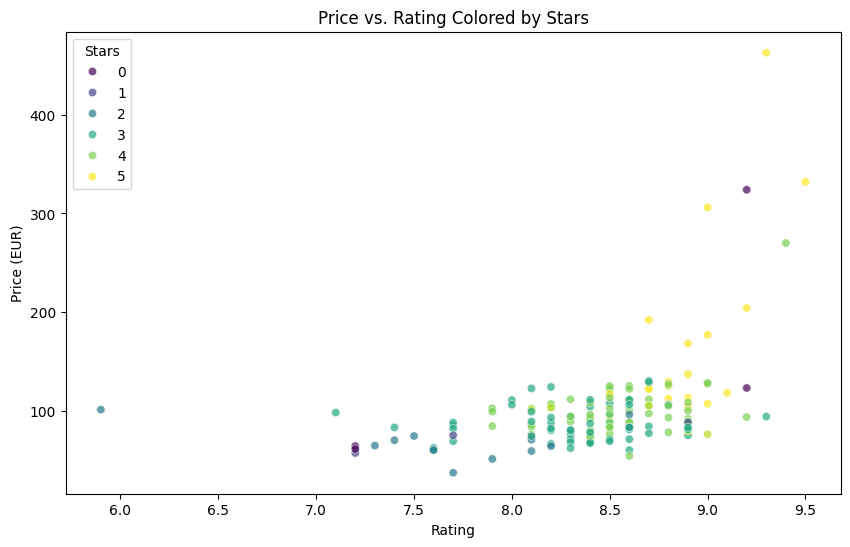

In [104]:
# Scatter plot of price vs. rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='rating', y='price', hue='star', palette='viridis', alpha=0.7)
plt.title('Price vs. Rating Colored by Stars')
plt.xlabel('Rating')
plt.ylabel('Price (EUR)')
plt.legend(title='Stars')
plt.show()

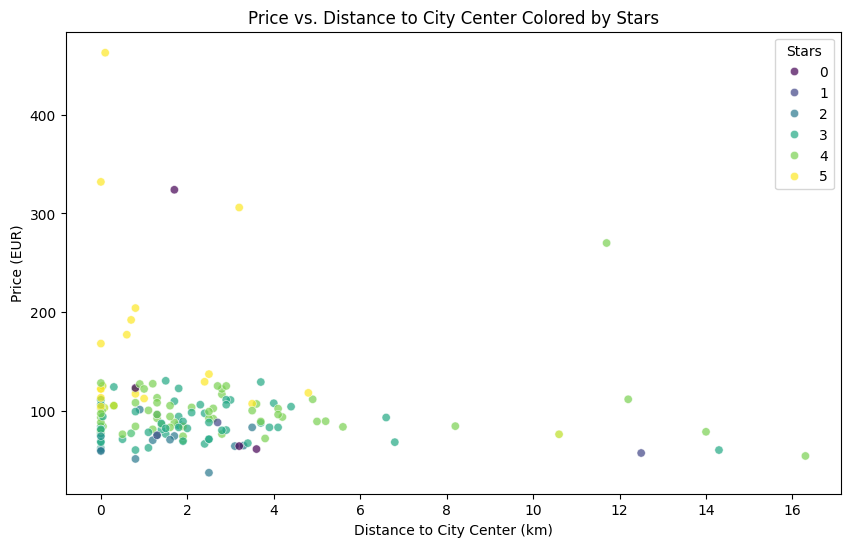

In [105]:
# Scatter plot of price vs. distance to city center
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='distance_to_city_center', y='price', hue='star', palette='viridis', alpha=0.7)
plt.title('Price vs. Distance to City Center Colored by Stars')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Price (EUR)')
plt.legend(title='Stars')
plt.show()

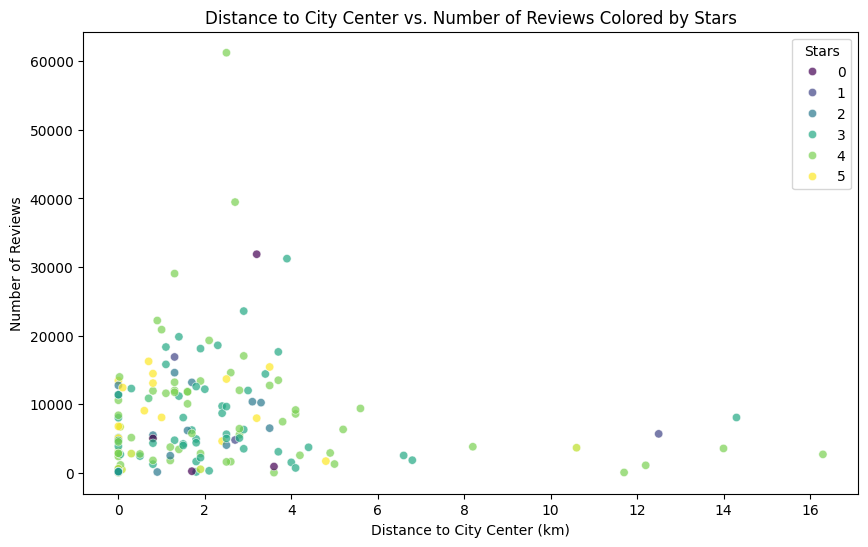

In [106]:
# Scatter plot of distance to city center vs. number of reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='distance_to_city_center', y='num_reviews', hue='star', palette='viridis', alpha=0.7)
plt.title('Distance to City Center vs. Number of Reviews Colored by Stars')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Number of Reviews')
plt.legend(title='Stars')
plt.show()

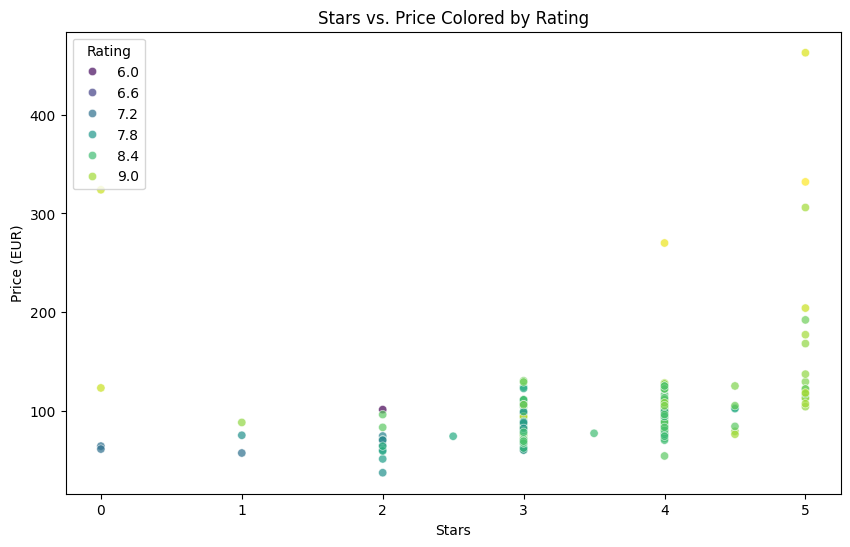

In [107]:
# Scatter plot of stars vs. price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='star', y='price', hue='rating', palette='viridis', alpha=0.7)
plt.title('Stars vs. Price Colored by Rating')
plt.xlabel('Stars')
plt.ylabel('Price (EUR)')
plt.legend(title='Rating')
plt.show()

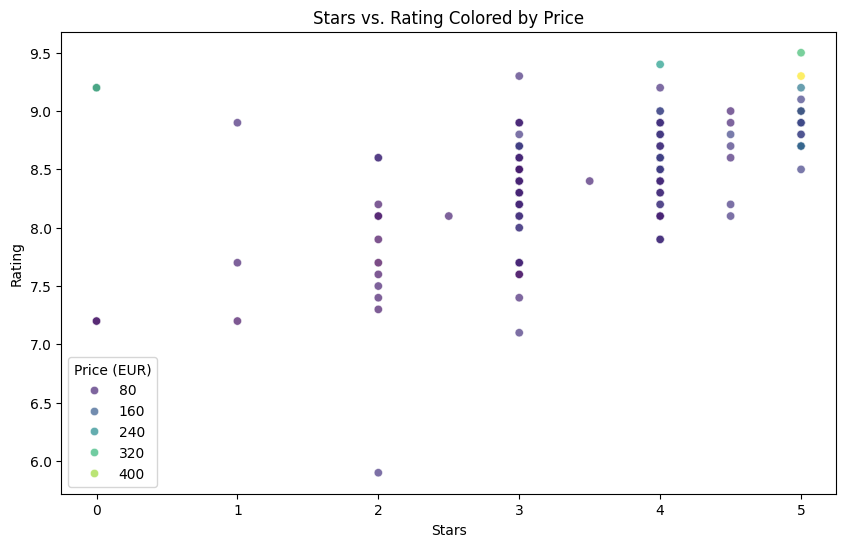

In [108]:
# Scatter plot of stars vs. rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='star', y='rating', hue='price', palette='viridis', alpha=0.7)
plt.title('Stars vs. Rating Colored by Price')
plt.xlabel('Stars')
plt.ylabel('Rating')
plt.legend(title='Price (EUR)')
plt.show()

/var/folders/zn/nwmpym2d70ld9cfczt1c5c780000gn/T/ipykernel_24612/810103446.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='star', y='rating', palette='viridis')


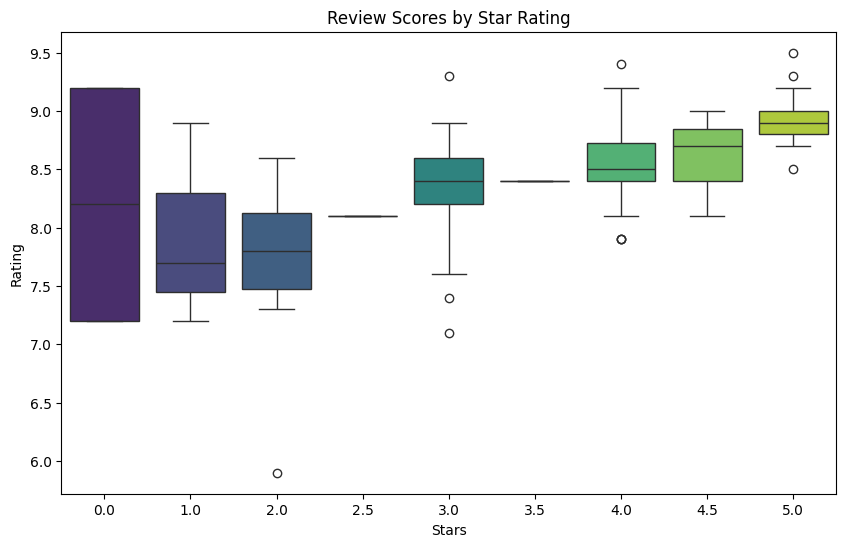

In [109]:
# Boxplot of review scores by star rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='star', y='rating', palette='viridis')
plt.title('Review Scores by Star Rating')
plt.xlabel('Stars')
plt.ylabel('Rating')
plt.show()

It seems that higher star ratings generally correspond to higher review scores, but there is still a wide range of ratings within each star category.

/var/folders/zn/nwmpym2d70ld9cfczt1c5c780000gn/T/ipykernel_24612/1001563165.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='star', y='price', palette='viridis')


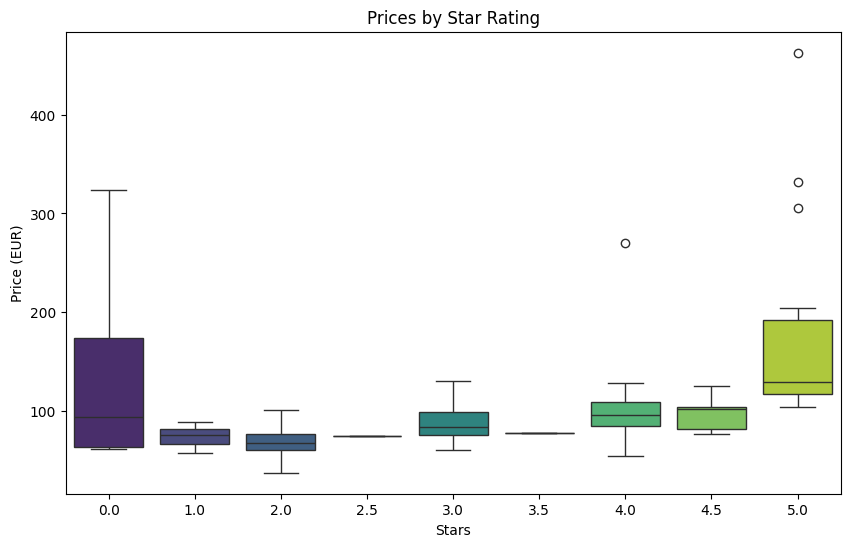

In [110]:
# Boxplot of prices by star rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='star', y='price', palette='viridis')
plt.title('Prices by Star Rating')
plt.xlabel('Stars')
plt.ylabel('Price (EUR)')
plt.show()

It seems that higher star ratings generally correspond to higher prices

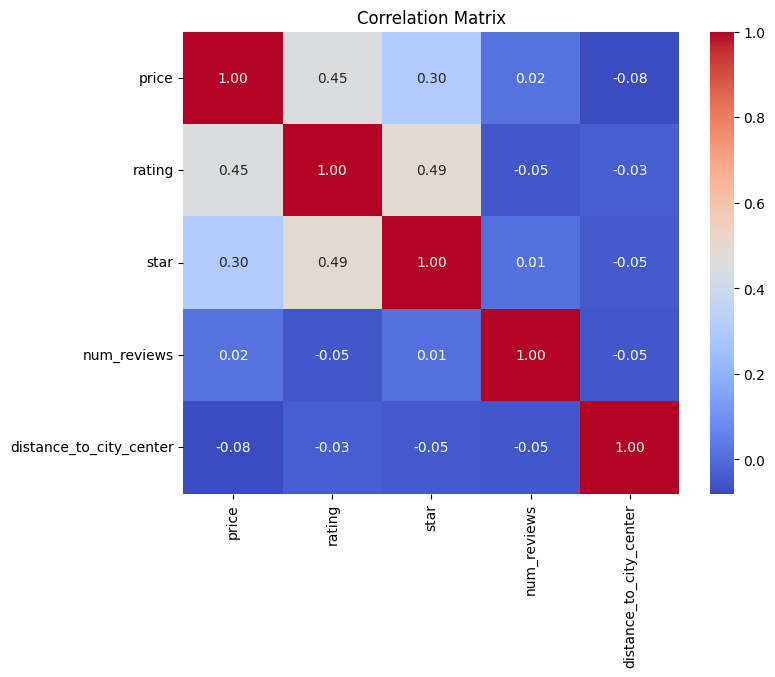

In [115]:
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = df_merged[['price', 'rating', 'star', 'num_reviews', 'distance_to_city_center']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## User interation

### Helper functions

In [116]:
def user_input_data():
    # Price range
    price_min = int(input("Enter minimum price: "))
    price_max = int(input("Enter maximum price: "))
    distance_max = float(input("Enter maximum distance to city center (km): "))
    stars_min = float(input("Enter minimum star rating (1-5): "))
    stars_max = float(input("Enter maximum star rating (1-5): "))
    score_min = float(input("Enter minimum review score (1-10): "))
    score_max = float(input("Enter maximum review score (1-10): "))
    sorted_by = input("Sort by (price, distance, stars, score): ")
    ascending = input("Ascending order? (yes/no): ").lower() == 'yes'

    usr_input = {
        'price_min': price_min,
        'price_max': price_max,
        'distance_max': distance_max,
        'stars_min': stars_min,
        'stars_max': stars_max,
        'score_min': score_min,
        'score_max': score_max,
        'sorted_by': sorted_by,
        'ascending': ascending
    }

    return usr_input


In [60]:
def choose_hotel_to_display(df):
    # Display the data in the scrollable table
    from IPython.display import display
    import ipywidgets as widgets

    # Select relevant columns to display
    display_columns = ['name', 'address', 'price', 'distance_to_city_center', 'star', 'rating']
    df = df[display_columns]
    height = '300px'  # Set the height of the scrollable area
    display(HTML(f"""
    <div style="height: {height}; overflow: auto; border: 1px solid #ccc;">
        {df.to_html()}
    </div>
    """))
    hotel_id = input("Enter the hotel_id of the hotel you want to see more details: ")

    return hotel_id

In [117]:
from IPython.display import HTML, display
import ast

def display_hotel_info(row):
    """
    Display hotel information in a beautiful format
    
    Parameters:
    row: pandas Series containing hotel data
    """
    
    # Extract data from the row
    hotel_name = row.iloc[0]
    hotel_url = row.iloc[1]
    review_score = row.iloc[2]
    num_reviews = row.iloc[3]
    price = row.iloc[4]
    location_info = str(row.iloc[5]) + " km from city center."
    hotel_rating = row.iloc[6] 
    description = row.iloc[7]
    images_str = row.iloc[8]
    address = row.iloc[9]
    
    try:
        images = ast.literal_eval(images_str)
        display_images = images[:3] if len(images) >= 3 else images
    except:
        display_images = []
    
    clean_price = str(price).replace('**', '') if price else 'N/A'
    
    stars = '★' * int(float(hotel_rating)) if hotel_rating != '**' else 'N/A'
    
    html_content = f"""
    <div style="
        max-width: 900px;
        margin: 20px auto;
        background: white;
        border-radius: 15px;
        box-shadow: 0 10px 30px rgba(0,0,0,0.1);
        overflow: hidden;
        font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
    ">
        <!-- Header -->
        <div style="
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 25px;
            text-align: center;
        ">
            <h1 style="margin: 0; font-size: 1.8em; font-weight: 600;">
                <a href="{hotel_url}" style="text-decoration: underline; color: inherit;">
                    {hotel_name}
                </a>
            </h1>
        </div>
        
        <!-- Content -->
        <div style="padding: 25px;">
            
            <!-- Info Grid -->
            <div style="
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 20px;
                margin-bottom: 25px;
            ">
                <!-- Address -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #4facfe;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">📍 Address</div>
                    <div style="font-size: 1em; color: #1e293b; font-weight: 500;">{address}</div>
                </div>
                
                <!-- Distance from Center -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #10b981;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">📏 Distance</div>
                    <div style="font-size: 1em; color: #1e293b; font-weight: 500;">{location_info}</div>
                </div>
                
                <!-- Price -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #059669;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">💰 Price per Night</div>
                    <div style="font-size: 1.4em; color: #059669; font-weight: 700;">€{clean_price}</div>
                </div>
                
                <!-- Review Score -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #f59e0b;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">⭐ Review Score</div>
                    <div style="font-size: 1.2em; color: #1e293b; font-weight: 600;">{review_score}/10</div>
                </div>
                
                <!-- Hotel Rating -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #dc2626;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">🏨 Hotel Rating</div>
                    <div style="font-size: 1.2em; color: #fbbf24; font-weight: 600;">{stars} ({hotel_rating})</div>
                </div>
                
                <!-- Number of Reviews -->
                <div style="
                    background: #f8fafc;
                    padding: 15px;
                    border-radius: 10px;
                    border-left: 4px solid #8b5cf6;
                ">
                    <div style="font-size: 0.8em; color: #64748b; text-transform: uppercase; margin-bottom: 5px; font-weight: 600;">💬 Reviews</div>
                    <div style="font-size: 1.2em; color: #1e293b; font-weight: 600;">{num_reviews} reviews</div>
                </div>
            </div>
            
            <!-- Description Section -->
            <div style="margin: 25px 0;">
                <h3 style="
                    font-size: 1.3em;
                    color: #1e293b;
                    margin-bottom: 10px;
                    font-weight: 600;
                    border-bottom: 2px solid #e2e8f0;
                    padding-bottom: 5px;
                ">📋 Description</h3>
                <div style="
                    line-height: 1.6;
                    color: #475569;
                    font-size: 1em;
                    background: #f1f5f9;
                    padding: 15px;
                    border-radius: 8px;
                    border-left: 4px solid #4facfe;
                ">{description}</div>
            </div>
            
            <!-- Photos Section -->
            <div style="margin-top: 25px;">
                <h3 style="
                    font-size: 1.3em;
                    color: #1e293b;
                    margin-bottom: 15px;
                    font-weight: 600;
                    border-bottom: 2px solid #e2e8f0;
                    padding-bottom: 5px;
                ">📸 Hotel Photos</h3>
                <div style="
                    display: grid;
                    grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                    gap: 15px;
                ">
    """
    
    for i, img_url in enumerate(display_images):
        html_content += f"""
                    <div style="
                        border-radius: 10px;
                        overflow: hidden;
                        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
                        transition: transform 0.3s ease;
                    ">
                        <img src="{img_url}" 
                             alt="Hotel Photo {i+1}" 
                             style="
                                 width: 100%;
                                 height: 200px;
                                 object-fit: cover;
                                 display: block;
                             "
                        />
                    </div>
        """
    
    html_content += """
                </div>
            </div>
        </div>
    </div>
    """
    
    return HTML(html_content)

In [64]:
def show_hotel(df, row_index=0):
    """
    Display hotel information for a specific row
    
    Parameters:
    df: pandas DataFrame containing hotel data
    row_index: index of the row to display (default: 0)
    """
    html_display = display_hotel_info(df.iloc[row_index])
    display(html_display)

In [65]:
def main_app(df):
    while True:
        usr_input = user_input_data()

        filtered_df = df[
            (df['price'] >= usr_input['price_min']) &
            (df['price'] <= usr_input['price_max']) &
            (df['distance_to_city_center'] <= usr_input['distance_max']) &
            (df['star'] >= usr_input['stars_min']) &
            (df['star'] <= usr_input['stars_max']) &
            (df['rating'] >= usr_input['score_min']) &
            (df['rating'] <= usr_input['score_max'])
        ]

        if usr_input['sorted_by'] in ['price', 'distance', 'stars', 'score']:
            sort_column = {
                'price': 'price',
                'distance': 'distance_to_city_center',
                'star': 'star',
                'rating': 'review_score'
            }[usr_input['sorted_by']]
            filtered_df = filtered_df.sort_values(by=sort_column, ascending=True if usr_input['ascending'] == "yes" else False)

        print("\nFiltered Accommodations:")
        while True:
            hotel_id = choose_hotel_to_display(filtered_df)
            print(f"\nYou selected hotel_id: {hotel_id}")
            show_hotel(df, row_index=int(hotel_id))
            is_another = input("Do you want to view another hotel? (yes/no): ").lower()
            if is_another != 'yes':
                break
        
        is_start_over = input("Do you want to start a new search? (yes/no): ").lower()
        if is_start_over != 'yes':
            print("Exiting the application.")
            break

### Main application

In [121]:
main_app(df_merged)


Filtered Accommodations:


,name,address,price,distance_to_city_center,star,rating
150,Park Inn by Radisson Berlin Alexanderplatz,"Alexanderplatz 7, 10178, Berlin, Germany",99.00,2.5,4.0,7.9
91,AR City Hotel Berlin,"Provinzstraße 16, Berlin, Wedding, Berlin, Germany, 13409",98.00,2.1,3.0,7.1
153,Hotel Tiergarten Berlin,"Alt-Moabit 89, 10559, Berlin, Germany",88.00,2.5,3.0,7.7
77,Wyndham Garden Berlin Mitte,"Osloer Strasse 116 a, Mitte, Berlin, Germany, 13359",85.00,1.8,3.0,7.7
106,The Rix Studios & Suites,"Saalestraße 72, Neukölln, Berlin, Germany, 12055",83.00,4.1,3.0,7.4
156,Hotel Berlin Mitte by Campanile,"Invalidenstraße 98, 10115, Berlin, Germany",82.00,1.5,3.0,7.7
29,a&o Berlin Hauptbahnhof,"Lehrter Str. 12-15, Mitte, 10557 Berlin, Germany",74.25,1.7,2.0,7.5
88,Happy Hotel Berlin,"Grunewaldstraße 33, Schöneberg, Berlin, Germany, 10823",70.00,1.2,2.0,7.4
72,Upper Room Hotel,"Rankestrasse 3., Charlottenburg, Berlin, Germany, 10789",69.00,0.0,3.0,7.7
25,a&o Berlin Mitte,"Köpenicker Str. 127-129, Mitte, 10179 Berlin, Germany",64.50,3.3,2.0,7.3



You selected hotel_id: 91


,name,address,price,distance_to_city_center,star,rating
150,Park Inn by Radisson Berlin Alexanderplatz,"Alexanderplatz 7, 10178, Berlin, Germany",99.00,2.5,4.0,7.9
91,AR City Hotel Berlin,"Provinzstraße 16, Berlin, Wedding, Berlin, Germany, 13409",98.00,2.1,3.0,7.1
153,Hotel Tiergarten Berlin,"Alt-Moabit 89, 10559, Berlin, Germany",88.00,2.5,3.0,7.7
77,Wyndham Garden Berlin Mitte,"Osloer Strasse 116 a, Mitte, Berlin, Germany, 13359",85.00,1.8,3.0,7.7
106,The Rix Studios & Suites,"Saalestraße 72, Neukölln, Berlin, Germany, 12055",83.00,4.1,3.0,7.4
156,Hotel Berlin Mitte by Campanile,"Invalidenstraße 98, 10115, Berlin, Germany",82.00,1.5,3.0,7.7
29,a&o Berlin Hauptbahnhof,"Lehrter Str. 12-15, Mitte, 10557 Berlin, Germany",74.25,1.7,2.0,7.5
88,Happy Hotel Berlin,"Grunewaldstraße 33, Schöneberg, Berlin, Germany, 10823",70.00,1.2,2.0,7.4
72,Upper Room Hotel,"Rankestrasse 3., Charlottenburg, Berlin, Germany, 10789",69.00,0.0,3.0,7.7
25,a&o Berlin Mitte,"Köpenicker Str. 127-129, Mitte, 10179 Berlin, Germany",64.50,3.3,2.0,7.3



You selected hotel_id: 88


,name,address,price,distance_to_city_center,star,rating
150,Park Inn by Radisson Berlin Alexanderplatz,"Alexanderplatz 7, 10178, Berlin, Germany",99.00,2.5,4.0,7.9
91,AR City Hotel Berlin,"Provinzstraße 16, Berlin, Wedding, Berlin, Germany, 13409",98.00,2.1,3.0,7.1
153,Hotel Tiergarten Berlin,"Alt-Moabit 89, 10559, Berlin, Germany",88.00,2.5,3.0,7.7
77,Wyndham Garden Berlin Mitte,"Osloer Strasse 116 a, Mitte, Berlin, Germany, 13359",85.00,1.8,3.0,7.7
106,The Rix Studios & Suites,"Saalestraße 72, Neukölln, Berlin, Germany, 12055",83.00,4.1,3.0,7.4
156,Hotel Berlin Mitte by Campanile,"Invalidenstraße 98, 10115, Berlin, Germany",82.00,1.5,3.0,7.7
29,a&o Berlin Hauptbahnhof,"Lehrter Str. 12-15, Mitte, 10557 Berlin, Germany",74.25,1.7,2.0,7.5
88,Happy Hotel Berlin,"Grunewaldstraße 33, Schöneberg, Berlin, Germany, 10823",70.00,1.2,2.0,7.4
72,Upper Room Hotel,"Rankestrasse 3., Charlottenburg, Berlin, Germany, 10789",69.00,0.0,3.0,7.7
25,a&o Berlin Mitte,"Köpenicker Str. 127-129, Mitte, 10179 Berlin, Germany",64.50,3.3,2.0,7.3



You selected hotel_id: 17


,name,address,price,distance_to_city_center,star,rating
150,Park Inn by Radisson Berlin Alexanderplatz,"Alexanderplatz 7, 10178, Berlin, Germany",99.00,2.5,4.0,7.9
91,AR City Hotel Berlin,"Provinzstraße 16, Berlin, Wedding, Berlin, Germany, 13409",98.00,2.1,3.0,7.1
153,Hotel Tiergarten Berlin,"Alt-Moabit 89, 10559, Berlin, Germany",88.00,2.5,3.0,7.7
77,Wyndham Garden Berlin Mitte,"Osloer Strasse 116 a, Mitte, Berlin, Germany, 13359",85.00,1.8,3.0,7.7
106,The Rix Studios & Suites,"Saalestraße 72, Neukölln, Berlin, Germany, 12055",83.00,4.1,3.0,7.4
156,Hotel Berlin Mitte by Campanile,"Invalidenstraße 98, 10115, Berlin, Germany",82.00,1.5,3.0,7.7
29,a&o Berlin Hauptbahnhof,"Lehrter Str. 12-15, Mitte, 10557 Berlin, Germany",74.25,1.7,2.0,7.5
88,Happy Hotel Berlin,"Grunewaldstraße 33, Schöneberg, Berlin, Germany, 10823",70.00,1.2,2.0,7.4
72,Upper Room Hotel,"Rankestrasse 3., Charlottenburg, Berlin, Germany, 10789",69.00,0.0,3.0,7.7
25,a&o Berlin Mitte,"Köpenicker Str. 127-129, Mitte, 10179 Berlin, Germany",64.50,3.3,2.0,7.3



You selected hotel_id: 25


,name,address,price,distance_to_city_center,star,rating
150,Park Inn by Radisson Berlin Alexanderplatz,"Alexanderplatz 7, 10178, Berlin, Germany",99.00,2.5,4.0,7.9
91,AR City Hotel Berlin,"Provinzstraße 16, Berlin, Wedding, Berlin, Germany, 13409",98.00,2.1,3.0,7.1
153,Hotel Tiergarten Berlin,"Alt-Moabit 89, 10559, Berlin, Germany",88.00,2.5,3.0,7.7
77,Wyndham Garden Berlin Mitte,"Osloer Strasse 116 a, Mitte, Berlin, Germany, 13359",85.00,1.8,3.0,7.7
106,The Rix Studios & Suites,"Saalestraße 72, Neukölln, Berlin, Germany, 12055",83.00,4.1,3.0,7.4
156,Hotel Berlin Mitte by Campanile,"Invalidenstraße 98, 10115, Berlin, Germany",82.00,1.5,3.0,7.7
29,a&o Berlin Hauptbahnhof,"Lehrter Str. 12-15, Mitte, 10557 Berlin, Germany",74.25,1.7,2.0,7.5
88,Happy Hotel Berlin,"Grunewaldstraße 33, Schöneberg, Berlin, Germany, 10823",70.00,1.2,2.0,7.4
72,Upper Room Hotel,"Rankestrasse 3., Charlottenburg, Berlin, Germany, 10789",69.00,0.0,3.0,7.7
25,a&o Berlin Mitte,"Köpenicker Str. 127-129, Mitte, 10179 Berlin, Germany",64.50,3.3,2.0,7.3



You selected hotel_id: 76


Exiting the application.
